In [1]:
import ee
import ee.mapclient
import geemap.geemap as geemap
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import imageio as iio

In [11]:
# ee.Authenticate()
ee.Initialize(project="ee-surfactant", opt_url='https://earthengine-highvolume.googleapis.com')

In [8]:
df = pd.read_csv('MichiganGrid-JustCoordinates.csv')
print(df.shape)

(1330147, 2)


In [4]:
square = json.loads(df.loc[0][".geo"])
print(type(square))
print(square)

<class 'list'>
[[[-84.80814934315579, 41.692608966555234], [-84.80455608201932, 41.692608966555234], [-84.80455608201932, 41.696202227691714], [-84.80814934315579, 41.696202227691714], [-84.80814934315579, 41.692608966555234]]]


In [5]:
polygon = ee.Geometry.Polygon(square[0])

sentinel_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(polygon) \
    .filterDate('2022-06-01', '2022-09-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5)) \
    .select('B2', 'B3', 'B4', 'B8') \
    .mosaic() \
    .clip(polygon)

In [6]:
cropland_data = ee.ImageCollection('USDA/NASS/CDL') \
    .filterBounds(polygon) \
    .filterDate('2022-01-01', '2022-12-31') \
    .first() \
    .clip(polygon)

In [7]:
dynamic_worlds = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
    .filterBounds(polygon) \
    .filter(ee.Filter.date('2021-04-02', '2021-04-03')) \
    .select('classification') \
    .mosaic() \
    .clip(polygon)

In [9]:
combined_image = ee.Image.cat([sentinel_image, cropland_data, dynamic_worlds])

In [10]:
# export image to google drive
task = ee.batch.Export.image(combined_image, description="testing-combined", config={ "scale": 1, "region": square, "maxPixels": 1e13 })
task.start()

In [ ]:
cdl = (
    ee.ImageCollection("USDA/NASS/CDL")
    .filter(ee.Filter.date("2018-01-01", "2019-12-31"))
    .first()
)

dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").filter(ee.Filter.date('2021-04-02', '2021-04-03'))

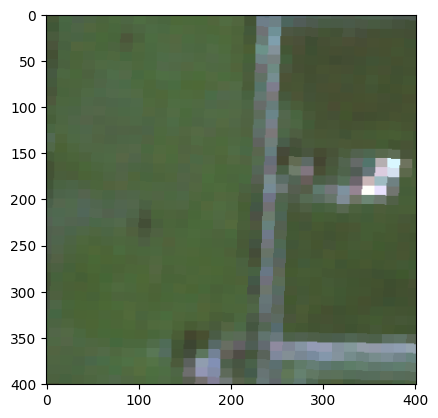

In [39]:
image = iio.v2.imread('./testingSentinel-1.tif')
image = np.array(image)
scaled_image = image / image.max(axis=0).max(axis=0)
plt.imshow(scaled_image[:, :, 0:3])

In [43]:
np.array(square)[0].mean(axis=0)

array([-84.80671204,  41.69404627])

In [44]:
square

[[[-84.80814934315579, 41.692608966555234],
  [-84.80455608201932, 41.692608966555234],
  [-84.80455608201932, 41.696202227691714],
  [-84.80814934315579, 41.696202227691714],
  [-84.80814934315579, 41.692608966555234]]]